<a href="https://colab.research.google.com/github/SruthiChilukuri/advanced_deep_learning/blob/master/finetuning_simclr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Simple contrsative learning(simclr version2) i.e. simclrv2 is appied on the flowers dataset from the Imagenet.**

- **Contrastive learning for visual representations learns representations from unlabeled data.**
- **It is measured in Noise Contrastive Estimator(NCE) loss**
- **similar elements are measured to be equal and dissimilar elements are measured to be different.**

we apply simclrv2 and compare without finetuning on the same dataset to compare performances.

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
import re

In [2]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

--2020-09-27 20:06:54--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2020-09-27 20:06:55 (102 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



In [3]:
imagenet_int_to_str = {}
with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})
tf_flowers_labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
FLAGS_color_jitter_strength = 0.3
CROP_PROPORTION = 0.875  # Standard for ImageNet.


def random_apply(func, p, x):
  """Randomly apply function func to x with probability p."""
  return tf.cond(
      tf.less(tf.random_uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


def random_brightness(image, max_delta, impl='simclrv2'):
  """A multiplicative vs additive change of brightness."""
  if impl == 'simclrv2':
    factor = tf.random_uniform(
        [], tf.maximum(1.0 - max_delta, 0), 1.0 + max_delta)
    image = image * factor
  elif impl == 'simclrv1':
    image = random_brightness(image, max_delta=max_delta)
  else:
    raise ValueError('Unknown impl {} for random brightness.'.format(impl))
  return image


def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image


def color_jitter(image,
                 strength,
                 random_order=True):
 
  brightness = 0.8 * strength
  contrast = 0.8 * strength
  saturation = 0.8 * strength
  hue = 0.2 * strength
  if random_order:
    return color_jitter_rand(image, brightness, contrast, saturation, hue)
  else:
    return color_jitter_nonrand(image, brightness, contrast, saturation, hue)


def color_jitter_nonrand(image, brightness=0, contrast=0, saturation=0, hue=0):
 
  with tf.name_scope('distort_color'):
    def apply_transform(i, x, brightness, contrast, saturation, hue):
      """Apply the i-th transformation."""
      if brightness != 0 and i == 0:
        x = random_brightness(x, max_delta=brightness)
      elif contrast != 0 and i == 1:
        x = tf.image.random_contrast(
            x, lower=1-contrast, upper=1+contrast)
      elif saturation != 0 and i == 2:
        x = tf.image.random_saturation(
            x, lower=1-saturation, upper=1+saturation)
      elif hue != 0:
        x = tf.image.random_hue(x, max_delta=hue)
      return x

    for i in range(4):
      image = apply_transform(i, image, brightness, contrast, saturation, hue)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
  
  with tf.name_scope('distort_color'):
    def apply_transform(i, x):
      """Apply the i-th transformation."""
      def brightness_foo():
        if brightness == 0:
          return x
        else:
          return random_brightness(x, max_delta=brightness)
      def contrast_foo():
        if contrast == 0:
          return x
        else:
          return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
      def saturation_foo():
        if saturation == 0:
          return x
        else:
          return tf.image.random_saturation(
              x, lower=1-saturation, upper=1+saturation)
      def hue_foo():
        if hue == 0:
          return x
        else:
          return tf.image.random_hue(x, max_delta=hue)
      x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                  lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
      return x

    perm = tf.random_shuffle(tf.range(4))
    for i in range(4):
      image = apply_transform(perm[i], image)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def _compute_crop_shape(
    image_height, image_width, aspect_ratio, crop_proportion):
  
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(tf.rint(
        crop_proportion / aspect_ratio * image_width_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * aspect_ratio *
        image_height_float), tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)


def center_crop(image, height, width, crop_proportion):
  
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  crop_height, crop_width = _compute_crop_shape(
      image_height, image_width, height / width, crop_proportion)
  offset_height = ((image_height - crop_height) + 1) // 2
  offset_width = ((image_width - crop_width) + 1) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, crop_height, crop_width)

  image = tf.image.resize_bicubic([image], [height, width])[0]

  return image


def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  
  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image


def crop_and_resize(image, height, width):
  
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize_bicubic([image], [height, width])[0]


def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  
  radius = tf.to_int32(kernel_size / 2)
  kernel_size = radius * 2 + 1
  x = tf.to_float(tf.range(-radius, radius + 1))
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.to_float(sigma), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    # Tensorflow requires batched input to convolutions, which we can fake with
    # an extra dimension.
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred


def random_crop_with_resize(image, height, width, p=1.0):
  
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)


def random_color_jitter(image, p=1.0):
  def _transform(image):
    color_jitter_t = functools.partial(
        color_jitter, strength=FLAGS_color_jitter_strength)
    image = random_apply(color_jitter_t, p=0.8, x=image)
    return random_apply(to_grayscale, p=0.2, x=image)
  return random_apply(_transform, p=p, x=image)


def random_blur(image, height, width, p=1.0):
  
  del width
  def _transform(image):
    sigma = tf.random.uniform([], 0.1, 2.0, dtype=tf.float32)
    return gaussian_blur(
        image, kernel_size=height//10, sigma=sigma, padding='SAME')
  return random_apply(_transform, p=p, x=image)


def batch_random_blur(images_list, height, width, blur_probability=0.5):
  
  def generate_selector(p, bsz):
    shape = [bsz, 1, 1, 1]
    selector = tf.cast(
        tf.less(tf.random_uniform(shape, 0, 1, dtype=tf.float32), p),
        tf.float32)
    return selector

  new_images_list = []
  for images in images_list:
    images_new = random_blur(images, height, width, p=1.)
    selector = generate_selector(blur_probability, tf.shape(images)[0])
    images = images_new * selector + images * (1 - selector)
    images = tf.clip_by_value(images, 0., 1.)
    new_images_list.append(images)

  return new_images_list


def preprocess_for_train(image, height, width,
                         color_distort=True, crop=True, flip=True):
  
  
  if crop:
    image = random_crop_with_resize(image, height, width)
  if flip:
    image = tf.image.random_flip_left_right(image)
  if color_distort:
    image = random_color_jitter(image)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_for_eval(image, height, width, crop=True):
 
  if crop:
    image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_image(image, height, width, is_training=False,color_distort=True, test_crop=True):
  
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  if is_training:
    return preprocess_for_train(image, height, width, color_distort)
  else:
    return preprocess_for_eval(image, height, width, test_crop)

**Using LARS optimizer: layer-wise adaptive scaling; using it for large batch training**

In [6]:
EETA_DEFAULT = 0.001

class LARSOptimizer(tf.train.Optimizer):
 

  def __init__(self,
               learning_rate,
               momentum=0.9,
               use_nesterov=False,
               weight_decay=0.0,
               exclude_from_weight_decay=None,
               exclude_from_layer_adaptation=None,
               classic_momentum=True,
               eeta=EETA_DEFAULT,
               name="LARSOptimizer"):
   
    super(LARSOptimizer, self).__init__(False, name)

    self.learning_rate = learning_rate
    self.momentum = momentum
    self.weight_decay = weight_decay
    self.use_nesterov = use_nesterov
    self.classic_momentum = classic_momentum
    self.eeta = eeta
    self.exclude_from_weight_decay = exclude_from_weight_decay
    # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
    # arg is None.
    if exclude_from_layer_adaptation:
      self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
    else:
      self.exclude_from_layer_adaptation = exclude_from_weight_decay

  def apply_gradients(self, grads_and_vars, global_step=None, name=None):
    if global_step is None:
      global_step = tf.train.get_or_create_global_step()
    new_global_step = global_step + 1

    assignments = []
    for (grad, param) in grads_and_vars:
      if grad is None or param is None:
        continue

      param_name = param.op.name

      v = tf.get_variable(
          name=param_name + "/Momentum",
          shape=param.shape.as_list(),
          dtype=tf.float32,
          trainable=False,
          initializer=tf.zeros_initializer())

      if self._use_weight_decay(param_name):
        grad += self.weight_decay * param

      if self.classic_momentum:
        trust_ratio = 1.0
        if self._do_layer_adaptation(param_name):
          w_norm = tf.norm(param, ord=2)
          g_norm = tf.norm(grad, ord=2)
          trust_ratio = tf.where(
              tf.greater(w_norm, 0), tf.where(
                  tf.greater(g_norm, 0), (self.eeta * w_norm / g_norm),
                  1.0),
              1.0)
        scaled_lr = self.learning_rate * trust_ratio

        next_v = tf.multiply(self.momentum, v) + scaled_lr * grad
        if self.use_nesterov:
          update = tf.multiply(self.momentum, next_v) + scaled_lr * grad
        else:
          update = next_v
        next_param = param - update
      else:
        next_v = tf.multiply(self.momentum, v) + grad
        if self.use_nesterov:
          update = tf.multiply(self.momentum, next_v) + grad
        else:
          update = next_v

        trust_ratio = 1.0
        if self._do_layer_adaptation(param_name):
          w_norm = tf.norm(param, ord=2)
          v_norm = tf.norm(update, ord=2)
          trust_ratio = tf.where(
              tf.greater(w_norm, 0), tf.where(
                  tf.greater(v_norm, 0), (self.eeta * w_norm / v_norm),
                  1.0),
              1.0)
        scaled_lr = trust_ratio * self.learning_rate
        next_param = param - scaled_lr * update

      assignments.extend(
          [param.assign(next_param),
           v.assign(next_v),
           global_step.assign(new_global_step)])
    return tf.group(*assignments, name=name)

  def _use_weight_decay(self, param_name):
    """Whether to use L2 weight decay for `param_name`."""
    if not self.weight_decay:
      return False
    if self.exclude_from_weight_decay:
      for r in self.exclude_from_weight_decay:
        if re.search(r, param_name) is not None:
          return False
    return True

  def _do_layer_adaptation(self, param_name):
    """Whether to do layer-wise learning rate adaptation for `param_name`."""
    if self.exclude_from_layer_adaptation:
      for r in self.exclude_from_layer_adaptation:
        if re.search(r, param_name) is not None:
          return False
    return True

**Tensorflow flowers dataset**

In [7]:
batch_size = 64
dataset_name = 'tf_flowers'

tfds_dataset, tfds_info = tfds.load(
    dataset_name, split='train', with_info=True)
num_images = tfds_info.splits['train'].num_examples
num_classes = tfds_info.features['label'].num_classes

def _preprocess(x):
  x['image'] = preprocess_image(
      x['image'], 224, 224, is_training=False, color_distort=False)
  return x
x = tfds_dataset.map(_preprocess).batch(batch_size)
x = tf.data.make_one_shot_iterator(x).get_next()

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [9]:
momentum = 0.9
weight_decay = 0
learning_rate = 0.1

# Load the base network and set it to non-trainable (for speedup fine-tuning)
hub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/'
module = hub.Module(hub_path, trainable=False)
key = module(inputs=x['image'], signature="default", as_dict=True)

# Attach a trainable linear layer to adapt for the new task.
with tf.variable_scope('head_supervised_new', reuse=tf.AUTO_REUSE):
  logits_t = tf.layers.dense(inputs=key['final_avg_pool'], units=num_classes)
loss_t = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=tf.one_hot(x['label'], num_classes), logits=logits_t))

# Setup optimizer and training op.
optimizer = LARSOptimizer(
    learning_rate,
    momentum=momentum,
    weight_decay=weight_decay,
    exclude_from_weight_decay=['batch_normalization', 'bias', 'head_supervised'])
variables_to_train = tf.trainable_variables() 
train_op = optimizer.minimize(
    loss_t, global_step=tf.train.get_or_create_global_step(),
    var_list=variables_to_train)

print('Variables to train:', variables_to_train)
key 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Variables to train: [<tf.Variable 'head_supervised_new/dense/kernel:0' shape=(2048, 5) dtype=float32>, <tf.Variable 'head_supervised_new/dense/bias:0' shape=(5,) dtype=float32>]


{'block_group1': <tf.Tensor 'module_1_apply_default/base_model/block_group1:0' shape=(None, 56, 56, 256) dtype=float32>,
 'block_group2': <tf.Tensor 'module_1_apply_default/base_model/block_group2:0' shape=(None, 28, 28, 512) dtype=float32>,
 'block_group3': <tf.Tensor 'module_1_apply_default/base_model/block_group3:0' shape=(None, 14, 14, 1024) dtype=float32>,
 'block_group4': <tf.Tensor 'module_1_apply_default/base_model/block_group4:0' shape=(None, 7, 7, 2048) dtype=float32>,
 'default': <tf.Tensor 'module_1_apply_default/base_model/final_avg_pool:0' shape=(None, 2048) dtype=float32>,
 'final_avg_pool': <tf.Tensor 'module_1_apply_default/base_model/final_avg_pool:0' shape=(None, 2048) dtype=float32>,
 'initial_conv': <tf.Tensor 'module_1_apply_default/base_model/initial_conv:0' shape=(None, 112, 112, 64) dtype=float32>,
 'initial_max_pool': <tf.Tensor 'module_1_apply_default/base_model/initial_max_pool:0' shape=(None, 56, 56, 64) dtype=float32>,
 'logits_sup': <tf.Tensor 'module_1_a

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Training for 20 iterations ; to calculate Noise Contrastive Estimator(NCE) loss**

In [11]:
total_iterations = 20
for it in range(total_iterations):
  _, loss, image, logits, labels = sess.run((train_op, loss_t, x['image'], logits_t, x['label']))
  pred = logits.argmax(-1)
  correct = np.sum(pred == labels)
  total = labels.size
  print("[Iter {}] Loss: {} Top 1: {}".format(it+1, loss, correct/float(total)))

[Iter 1] Loss: 1.7414796352386475 Top 1: 0.234375
[Iter 2] Loss: 2.2890851497650146 Top 1: 0.25
[Iter 3] Loss: 1.6446455717086792 Top 1: 0.640625
[Iter 4] Loss: 1.8109017610549927 Top 1: 0.5625
[Iter 5] Loss: 1.5984338521957397 Top 1: 0.671875
[Iter 6] Loss: 0.7116855382919312 Top 1: 0.8125
[Iter 7] Loss: 1.1316487789154053 Top 1: 0.75
[Iter 8] Loss: 1.032984972000122 Top 1: 0.765625
[Iter 9] Loss: 0.4453383684158325 Top 1: 0.890625
[Iter 10] Loss: 0.837673008441925 Top 1: 0.828125
[Iter 11] Loss: 0.6638016700744629 Top 1: 0.84375
[Iter 12] Loss: 1.0685278177261353 Top 1: 0.8125
[Iter 13] Loss: 1.5371737480163574 Top 1: 0.8125
[Iter 14] Loss: 0.880776047706604 Top 1: 0.828125
[Iter 15] Loss: 0.7299505472183228 Top 1: 0.8125
[Iter 16] Loss: 0.7350101470947266 Top 1: 0.875
[Iter 17] Loss: 0.44379761815071106 Top 1: 0.953125
[Iter 18] Loss: 0.9452681541442871 Top 1: 0.796875
[Iter 19] Loss: 1.2441786527633667 Top 1: 0.84375
[Iter 20] Loss: 1.291061520576477 Top 1: 0.8125


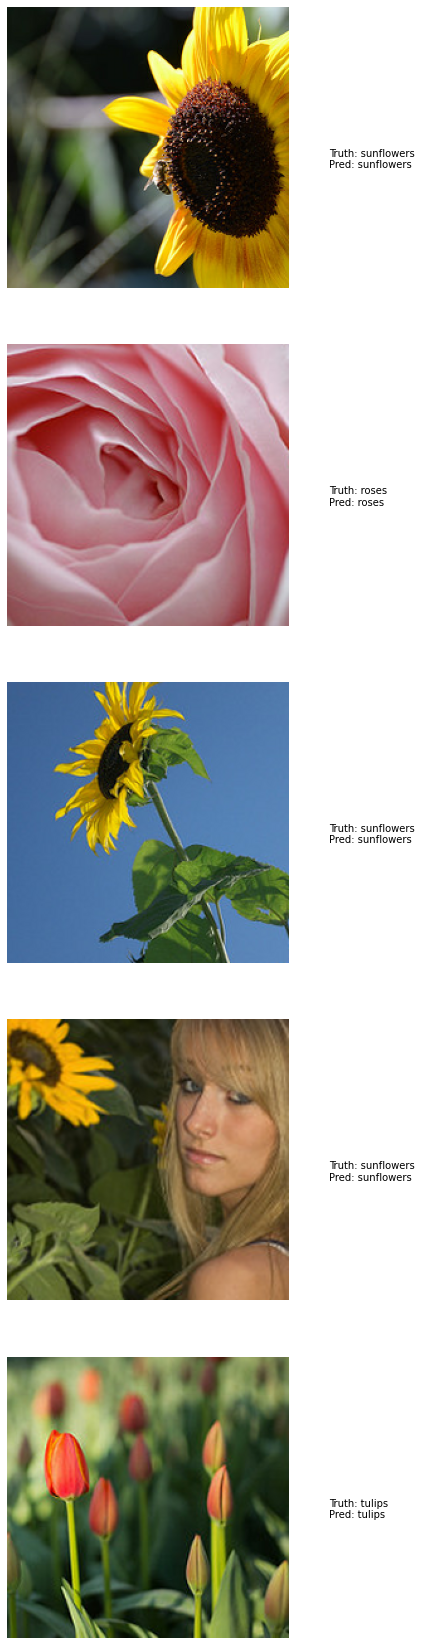

In [26]:
fig, axes = plt.subplots(5, 1, figsize=(30, 30))
for i in range(5):
  axes[i].imshow(image[i])
  true_text = tf_flowers_labels[labels[i]]
  pred_text = tf_flowers_labels[pred[i]]
  axes[i].axis('off')
  axes[i].text(256, 128, 'Truth: ' + true_text + '\n' + 'Pred: ' + pred_text)

###**Without simclrv2; training the same flowers dataset using a resnet model; with 5 classes of flowers**

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
split = (80, 10, 10)
splits = tfds.Split.TRAIN.subsplit(weighted=split)

In [17]:
batch_size = 32
# 5 types of flowers
num_classes = 5
# training for 1 epoch
epochs = 1
# size of each image
IMAGE_SHAPE = (224, 224, 3)

In [18]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

IMAGE_SHAPE = (224, 224)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

228818944/228813984 [==============================] - 5s 0us/step
Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [19]:
feature_extractor_url ="https://tfhub.dev/tensorflow/resnet_50/feature_vector/1" 
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))

In [20]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [21]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 23,571,397
Trainable params: 10,245
Non-trainable params: 23,561,152
_________________________________________________________________


In [22]:
predictions = model(image_batch)

In [23]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [25]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
batch_stats_callback = CollectBatchStats()
history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 549s 5s/step - batch: 57.0000 - size: 31.9130 - loss: 0.4823 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 549s 5s/step - batch: 57.0000 - size: 31.9130 - loss: 0.2442 - acc: 0.9688


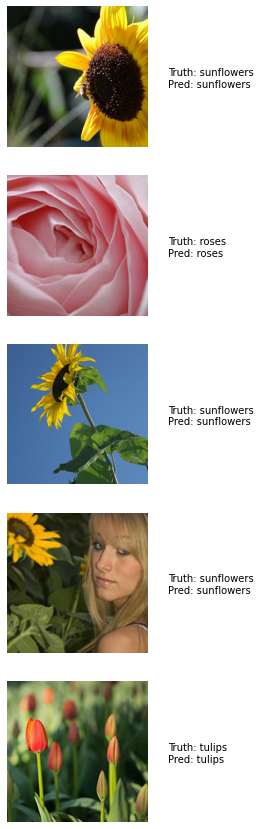

In [27]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
for i in range(5):
  axes[i].imshow(image[i])
  true_text = tf_flowers_labels[labels[i]]
  pred_text = tf_flowers_labels[pred[i]]
  axes[i].axis('off')
  axes[i].text(256, 128, 'Truth: ' + true_text + '\n' + 'Pred: ' + pred_text)

As we compare both; the loss factor when simclrv2 was used is 1.29; while without using the simclr method; the loss factor was 2.5.